# Amazon Reviews Sentiment Analysis

    My Amazon Reviews Sentiment Analyzer is a script that scrapes real-world products from Amazon UK and compiles meaningful data based on customer feedback. First, an Amazon product's customer reviews and other relevant details are fetched and stored. Then, these reviews are cleaned and prepared to be processed. Next, these cleaned reviews are sentimentally analyzed to obtain word clouds, polarity scores, and graphical representations of the summarized data. Lastly, positive and negative feedback is evaluated and presented.

In [ ]:
!pip install wordcloud
!pip install bs4
!pip install pandas
!pip install numpy
!pip install requests
!pip install matplotlib
!pip install nltk
!pip install seaborn

In [1]:
#packages and libraries used
import numpy as np
import pandas as pd
import re #to filter a string
import math

#Web Scraping - packages and libraries
import requests
from bs4 import BeautifulSoup

#Data Preprocessing - packages, libraries, and modules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt') #for the tokenizer
nltk.download('stopwords') #for the stopwords 

#Sentiment Analysis Processing - packages, libraries, and modules
#Documentation for the vader: https://www.nltk.org/_modules/nltk/sentiment/vader.html
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') #for the sentiment analysis
nltk.download('wordnet') #for the lemmatization
nltk.download('averaged_perceptron_tagger') #to determine the part of speech

#Displaying results
import matplotlib.pyplot as plt
import seaborn as sbn
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\megat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\megat\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\megat\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Web Scraping

In [2]:
#Web scraping to generate customized data set
#The goal is to find Amazon product's customer reviews from live products and store them effectively
#For each review, retrieve a variety of information about Amazon products using its webpage's HTML code.
#The code contains generalized attribute descriptions that can be scraped.
    
#The process of web scraping is broken down into three main steps:
    #First, get the URL and the HTML code of the webpage
    #Next, find out how many total review pages there are to be scraped. 
    #Then, find the reviews in the HTML code and extract the required information about the reviews for a product.
    #Lastly, keep scraping until the last page that has reviews is scraped
    
def getReviewsOnPage(urlLink, listOfAllReviews):
    '''
    Get the HTML code and scrape it to find customer reviews for an Amazon product 
    '''
    #get HTML code
    code = BeautifulSoup(requests.get(urlLink).content, 'html.parser')
    
    #find the divs that contain the reviews from the HTML code of the Amazon product page
    reviews = code.find_all("div", {'data-hook': 'review'})

    reviewDict = []
    #scrape and store the name of the item, the title of the review, the review's rating, date the review is posted, and the 
        #review text for each review.
    for each in reviews:
        try:
            reviewDict = {
                #filter the data and remove all the extra white spaces.
                'Product': code.title.text.replace("Amazon.co.uk:Customer reviews: ", "").strip(),
                'Review Title': each.find("a", {'data-hook': 'review-title'}).text.strip(),
                'Rating': each.find("i", {'data-hook': 'review-star-rating'}).text.replace('.0 out of 5 stars', '').strip(),
                'Date': each.find("span", {'data-hook': 'review-date'}).text.split(" on ")[1].strip(),
                'Original Review': each.find("span", {'data-hook': 'review-body'}).text.strip(),
            }
            listOfAllReviews.append(reviewDict)
        except:
            #ignore the reviews that are missing data or are written in any language other than English
            pass
    return code

def getTotalNumOfPages(urlLink):
    '''
    Evaluate the number of total pages that have product reviews
    '''
    urlLink = f'{urlLink}1'
    
    #get HTML code
    code = BeautifulSoup(requests.get(urlLink).content, 'html.parser')
    
    #find the number of total reviews
    numOfPages = code.find('div', {'data-hook': "cr-filter-info-review-rating-count"}).text
    numOfPages = numOfPages.split(" global reviews")
    numOfPages = int(numOfPages[0].split("| ")[1].replace(',', ''))
    
    #find the number of pages that have reviews
    numOfPages = math.ceil(numOfPages/10)
    
    return numOfPages


def getAllReviews(url, listOfAllReviews):
    '''
    Keep scraping and updating the link passed in as a parameter to obtain all the reviews.
    '''
    #get the total number of pages to scrape. This way once there are no more pages or reviews to find, stop scraping.
    numToScrape = int(getTotalNumOfPages(url))+1
    print(f'Total pages to scrape: {numToScrape-1}\n')
    
    #the loop will keep running for the number of pages there are to scrape
    for num in range(1,numToScrape):
        
        print(f'Current Page Being Scraped: {num}')
        
        #Note: Each review URL starting at the first review until the end has a similar link, except the last number. 
            #Based on the page number, the last number of the link will reflect that number.
            #For example, the 3rd page of reviews for a product will have a link that ends with 3. 
            #Other than this, the link is identical to other review pages for this product.
        code = getReviewsOnPage(f'{url}{num}', listOfAllReviews)
        
        print(f'Number of Total Reviews: {len(listOfAllReviews)}\n')
        
        #If there are no more reviews, then the next page does not exist. 
            #Thus, the "Next Page" button is disabled and has these classes.
            #Until the scraper does not find these classes, there are more reviews, so the scraping continues
        if code.find('li', {'class': 'a-disabled a-last'}):
            break
        else:
            pass

# Preprocessing

In [3]:
#Preprocess all the reviews to be cleaned
#Now that we have generated a customized data set, the reviews need to prepared in order to be ready to be sentimentally analyzed.
    #Note: The dictionary that contained details about the product and each review, rating, etc will be stored in a Pandas Dataframe.
    #This df contains the product name, review title, review rating, review date, and review text
    
#This preprocessing has been broken down into five main steps:
#Note: The reviews are located in the df's "Original Review" column
    #First, create a copy of the 'Original Review' column that will contain the edited reviews in the'Edited Review' column
    #Next, remove any characters that are unneeded such as @mentions, #'s, URLs, or any punctuation from the reviews
    #Then, the reviews are all turned to lowercase and then tokenized to break down each review message into a list of words
    #After that, these words are lemmatized so the list only contain root words and stop words are removed
        #Note: stop words are words that do not have any sentiment like "the" or "a"
    #Lastly, convert the list into a string that will make the sentimental analysis processing easier

#The goal of the preprocessing is that the df's "Edited Review" column should each contain a string of important words to represent 
    #the respective review

def editedReviewCol(dataframe):
    '''
    Create the 'Edited Review' column in the dataframe
    '''
    changedReviews = dataframe["Original Review"].copy()
    dataframe = pd.concat([dataframe, changedReviews.rename("Edited Review")], axis=1)
    return dataframe


def removeFromReviews(myReviews):
    '''
    Removing unwanted characters from reviews
    '''
    myReviews = re.sub(r'@[A-Za-z0-9]+', '', myReviews) #remove @mentions that reply or address any user
    myReviews = re.sub(r'#', '', myReviews) #remove any '#'s
    myReviews = re.sub(r'https?:\/\/\S+', '', myReviews) #remove any URLs
    myReviews = re.sub(r'[^\w\s]', "", myReviews) #remove punctuation 
    
    return myReviews


def tokenizeReviews(myReviews):
    '''
    Tokenization and turn all the reviews to lowercase
    '''
    num = 0
    for message in myReviews:
        
        #convert reviews' text to lowercase
        lowerReviews = message.lower()
    
        #Tokenization = break up each review message into words using a tokenizer
        #For example: "i like to code" get broken up into "['i', 'like', 'to', 'code']"
        myReviews[num] = word_tokenize(lowerReviews)
        
        num+=1
        
        
def lemmatizeReviews(myReviews):
    '''
    Lemmatization and removing stopwords for each review
    '''
    #generate the list of the stopWords
    stopWords = stopwords.words('english')
    
    #add to the list of stopwords
    stopWords.append("dont")
    stopWords.append("wont")
    stopWords.append("cant")
    stopWords.append("werent")
    stopWords.append("shouldnt")
    stopWords.append("couldnt")
    stopWords.append("wouldn't")
    stopWords.append("its")
    stopWords.append("doesnt")
    stopWords.append("mine")
    
    #generate the lemmatizer
    lem = WordNetLemmatizer()
    
    num = 0
    for words in myReviews:
        wordsList = []
        for word in words:
            
            #Lemmatize each word in the review so they are only root words
            #For example, "apples" becomes 'apple' and "talked" becomes 'talk'
            word = lem.lemmatize(word)
            
            if not word in stopWords:
                wordsList.append(word)
        myReviews[num] = wordsList
        num+=1
        
        
#At this point, the dataframe that has the edited reviews is a list of the important words for each review. 
#In order to sentimentally analyze the reviews, each list needs to be converted to a string
def convertToString(myReviews):
    '''
    Convert the list containing words into one string for each review
    '''
    for val in range (0,len(myReviews)):
        para = ""
        for num in range (0,len(myReviews[val])):
            para += myReviews[val][num] + " "
        myReviews[val] = para

# Sentiment Analysis - Breakdown the Reviews

In [4]:
#Processing all the reviews
#Now that we have cleaned and prepared reviews in the "Edited Column" of the dataframe, they need to be sentimentally analyzed.
#There are multiple insights to gain from the data and have been broken down below:
    #1. Get the polarity score using the nltk SentimentIntensityAnalyzer which gives the positive, negative, neutral, and 
          #compound score of any string of words/sentences.
            #Note: The compound score is the sum of positive, negative, and neutral scores which is then modified to be in 
                #range between -1 (negative) and +1 (positive)
            #These polarity scores are calculated for each review based on the 'Edited Reviews' column.
            #Find the score analysis which is type of each review based on the compound scores
            #A new dataframe is created that contains contents from both the old dataframe, like product, date, reviews (old and edited), etc., 
                #the newly calculated polarity scores, and the score analysis.
            #This new data can now be used to draw conclusions that are both numerically and graphically represented
    #2. Generate a word cloud that displays words that appear most often in all the reviews. 
            #This demonstrates how the product was perceived by most of the users in a visual graphic.
    #3. Create three barplots that evaluate the relationship between type of review (positive, neutral, and negative) and the customer given 
          #rating for those reviews
            #From these plots, we can gather that:
                #for the positive reviews, there are overall higher positive compound scores for higher ratings
                #for the negative reviews, there are overall higher negative compound scores for lower ratings
                #for the neutral reviews, there are overall higher compound scores for all ratings
                #Note: there can some outliers that affect the graphs
    #4. Displays the number of positive, negative, and neutral reviews this product received through a bar plot
            #This shows how the customer's felt about the product

def polarityScoreAnalysis(myReviews, dataframe):
    '''
    Create a new dataframe that shows the reivews, their respective polarity scores (positive, negative, neutral, and compound), and the 
    analysis of the type of review (Positive, Neutral, Negative)
    '''
    #generate the SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    
    scoreList = []
    scoreAnalysis = []
    
    #For each review, calculate the polarity scores and then analyze the type of review based on the compound score
    for review in myReviews:
        score = sia.polarity_scores(review)
        scoreList.append(score)
        if score['compound'] > 0:
            scoreAnalysis.append("Positive")
        elif score['compound'] < 0:
            scoreAnalysis.append("Negative")
        else:
            scoreAnalysis.append("Neutral")

    #create two dataframes with the polarity score and the type for each review
    polarity = pd.DataFrame(scoreList)
    analysis = pd.DataFrame(scoreAnalysis)
    
    #combine the current dataframe, the polarity scores, and the score analysis
    reviews_vader = pd.concat([dataframe, polarity, analysis], axis=1)
    
    #The 'analysis' column currently is named 0 so change the name of the column to what is should be: 'analysis'
    reviews_vader = reviews_vader.rename(columns={0: 'analysis'})

    return reviews_vader


def createWordCloud(myReviews):
    '''
    Create a word cloud based on the words frequency in the reviews
    '''
    wordsTotal=""
    for words in myReviews:
        #combine all the words in each edited review into one large string
        wordsTotal += "".join(words)
   
    #create a word cloud
    wordCloud = WordCloud(min_word_length=3, height=1000, width=1500, background_color='white').generate(wordsTotal) 
    plt.axis("off")
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.show()
    
    
def threeBarPlots(dataframe):
    '''
    Create 3 barplots that compares the type of review (positive, neutral, and negative) and the customer given rating
    '''
    f, bwp = plt.subplots(1, 3, figsize=(14, 3))
    
    #Positive vs Rating
    plot1 = sbn.barplot(data=dataframe, x='Rating', y='pos', ax=bwp[0])
    bwp[0].set_title('Positive Ratings vs Positive Sentimental Score')
    plot1.set(xlabel="Review Ratings", ylabel="Positive Score (+)")
    
    #Neutral vs Rating
    plot2 = sbn.barplot(data=dataframe, x='Rating', y='neu', ax=bwp[1])
    bwp[1].set_title('Neutral Ratings vs Neutral Sentimental Score')
    plot2.set(xlabel="Review Ratings", ylabel="Neutral Score")

    #Negative vs Rating
    plot3 = sbn.barplot(data=dataframe, x='Rating', y='neg', ax=bwp[2])
    bwp[2].set_title('Negative Ratings vs Negative Sentimental Score')
    plot3.set(xlabel="Review Ratings", ylabel="Negative Score (-)")

    plt.tight_layout()
    plt.show()
    

def reviewTypeCount(dataframe):
    '''
    Graph the number of positive, negative, and neutral reviews
    '''
    plt.title("Number of Review Types")
    plt.xlabel("Sentiment Type")
    plt.ylabel("Number of Reviews")
    dataframe['analysis'].value_counts().plot(kind="bar")
    plt.show()

# Sentiment Analysis - Feedback

In [5]:
#Providing the user comprehensive feedback (Positive and Negative)
#For the product selected, I further broken down the reviews into word pairings that were most commonly used based on the frequency.
#Then, I visually presented the customer feedback of what they liked and what they disliked
#This process is broken down into three parts:
    #1. Find the word pairings that are meaningful and give insight onto the customer's perspective.
            #From the 'Edited Reviews' column in the dataframe, I tokenized the string of important words from the reviews to be split 
                #up into a list words again.
            #Next, I found of the part of speech of each word in the list.
            #Then, I pulled combinations of two words that associate with each other in a specific format: adjective noun.
                #The reason I believe this was effective is because of this logic:
                    #Nouns alone would not provide too much insight.
                        #For example, a pencil product might have words that are nouns like "pencil" or "tip". These do not provide much input.
                    #Verbs alone would not provide too much insight either.
                        #For example, a pencil product might have words that are verbs like "write" or "erase". These do not provide much input.
                    #Adjectives alone would not provide too much insight either.
                        #For example, a pencil product might have words that are adjectives like "yellow" or "short". These do not provide much input.
                #Thus, semantically the combination of 'adjective noun' seemed to produce the best customer feedback since this word pairing 
                    #provides how a customer feels about a feature of a product.
                #After finding 'adjective noun' word pairings, I filtered them even more to ensure that the word pairing's polarity score 
                    #matched the type of feedback.
    #2. Next, I found the frequency of the 'adjective noun' word pairings. Many pairings were repeated so I kept a count of them using a dictionary.
            #To avoid a extremely large number of word pairings, I filtered the dictionary based on the number of occurrences and word pairings.
    #3. Lastly, I displayed a horizontal bar plot to showcase the feedback in a concise manner.
            #Based on the number of word pairings, I determined the size of the horizontal bar plot

def findConnectingReviews(dataFrameCol, posOrNeg):
    '''
    Compile a list of phrases that are arranged in 'adjective noun' order based on the part of speech and polarity score
    '''
    #generate the SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    
    reviewInsight = []
    for message in dataFrameCol:
        myList = []
        
        #tokenize the string of words to a list of words and then find the part of speech for each word
        myList = nltk.pos_tag(word_tokenize(message))
        for num in range (0, len(myList)-1):
            
            #find 'adjective noun' word pairings
            if myList[num][1] == 'JJ' and myList[num+1][1] == 'NN':
                
                #only add the word pairing if it still has a positive or negative polarity score based on the type of feedback
                    #The reason this is important is that some reviews might be negative or positive but have contradictory phrases that are 
                        #not accurate to the holistic type of review.
                    #For example, a negative review could be "Even though I liked the pretty color of the brown shelf, it had bad storage space".
                        #In this case, this negative review's word pairings would be 'pretty color', 'brown shelf', and 'bad storage'.
                        #The phrases 'pretty color' and 'brown shelf' are not negative word pairings, so they should not be included in the 
                            #final negative feedback
                        #On the other hand, "bad storage" is a negative word pairing, so it should be included in the final negative feedback
                if posOrNeg == 'Positive' and sia.polarity_scores(f'{myList[num][0]} {myList[num+1][0]}')['pos'] > 0:
                    reviewInsight.append(f'{myList[num][0]} {myList[num+1][0]}')
                elif posOrNeg == 'Negative' and sia.polarity_scores(f'{myList[num][0]} {myList[num+1][0]}')['neg'] > 0:
                    reviewInsight.append(f'{myList[num][0]} {myList[num+1][0]}')
    return reviewInsight


def findFreq(myList):
    '''
    Find the frequency of the word pairings and alter the size of the dictionary based on the number of occurrences and word pairings 
    '''
    #find frequencies and store them into a dictionary
    pairDict = {}
    for phrase in myList:
        num = 0
        if phrase in pairDict:
            num = pairDict[phrase]
            num+=1
        else:
            num+=1
        pairDict[phrase] = num
        
    #count the number of different frequency occurrences
    totalDictLen = len(pairDict)
    numOfOneOccurrence = list(pairDict.values()).count(1)
    numOfTwoOccurrence = list(pairDict.values()).count(2)
    numOfThreeOccurrence = list(pairDict.values()).count(3)
    numOfFourOccurrence = list(pairDict.values()).count(4)
    numOfFiveOccurrence = list(pairDict.values()).count(5)

    #filtering the dictionary to avoid a large dictionary
    finalDict = {}
    for pair in myList:
        #if there are more than 50 pharses that are not included in the word pairing frequencies of one, two, three, four, or five, then 
            #filter the dictionary to only have words pairings with frequencies more than 1,2,3,4, and 5
        if (totalDictLen - numOfOneOccurrence - numOfTwoOccurrence - numOfThreeOccurrence - numOfFourOccurrence - numOfFiveOccurrence) > 50:
            if pairDict[pair] != 1 and pairDict[pair] != 2 and pairDict[pair] != 3 and pairDict[pair] != 4 and pairDict[pair] != 5:
                finalDict[pair] = pairDict[pair]
        #if there are more than 25 pharses that are not included in the word pairing frequencies of one, two, or three, then filter the 
            #dictionary to only have words pairings with frequencies more than 1,2, and 3
        elif (totalDictLen - numOfOneOccurrence - numOfTwoOccurrence - numOfThreeOccurrence) > 25:
            if pairDict[pair] != 1 and pairDict[pair] != 2 and pairDict[pair] != 3:
                finalDict[pair] = pairDict[pair]
        #if there are more than 10 pharses that are not included in the word pairing frequencies of one, then filter the dictionary to only 
            #have words pairings with frequencies more than 1
        elif (totalDictLen - numOfOneOccurrence) > 10:
            if pairDict[pair] != 1:
                finalDict[pair] = pairDict[pair]
        #if less than 10 pharses occur more than once, then no change to the dictionary
        else:
            finalDict = pairDict
    return finalDict


def feedbackBarPlot(x,y, reviewType, plotColor):
    '''
    Display a horizontal bar plot
    '''
    if len(x) > 0:
        #adjust the horizontal bar plot size based on the number of word pairings
        if(len(x) > 90):
            f, ax = plt.subplots(figsize=(18,18))
        elif (len(x) > 50):
            f, ax = plt.subplots(figsize=(16,16))
        elif (len(x) > 27):
            f, ax = plt.subplots(figsize=(14,14))
        elif(len(x) > 10):
            f, ax = plt.subplots(figsize=(12,12))
        elif(len(x) > 5):
            f, ax = plt.subplots(figsize=(9,9))
        else:
            f, ax = plt.subplots(figsize=(5,5))
    
        #create the horizontal bar plot
        plt.barh(y, x, align='center', color=plotColor)
        plt.title(f'Product {reviewType} Feedback', fontsize=14, weight='bold')
        plt.ylabel('Feedback', fontsize=10, weight='bold')
        plt.xlabel('Frequency', fontsize=10, weight='bold')
        plt.locator_params(axis="x", integer=True)
        plt.show()
    else:
        print("no negative phrases feedback detected!")

# Run the Amazon Reviews Sentiment Analysis

In [6]:
#Web scraping

#prepare list of dictionaries
listOfAllReviews = []

'''
Test the list of a couple products preselected below or read instructions on how to pick products to analyze
Format: getAllReviews(URL, listOfAllReviews)
'''
#Product Examples:
'''
Uncomment any of the getAllReviews() function calls below to run the analysis on the preselected Amazon products
'''
#1. Roku Express | HD Streaming Media Player
getAllReviews("https://www.amazon.co.uk/product-reviews/B07XGMNK9G/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=", listOfAllReviews)

#2. Zebra Pen 22210 Z-Grip Retractable Ballpoint:
# getAllReviews("https://www.amazon.co.uk/product-reviews/B0006HXAW2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=", listOfAllReviews)

#3. Umbra Orchid Jewelry Hanging Tree Stand:
# getAllReviews("https://www.amazon.co.uk/product-reviews/B005M8YXEY/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=", listOfAllReviews)

#4. Sony WH-CH510 Wireless Bluetooth Headphones with Mic:
# getAllReviews("https://www.amazon.co.uk/product-reviews/B07WD58H6R/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=", listOfAllReviews)

#5. Milliard Reading Pillow with Shredded Memory Foam
# getAllReviews("https://www.amazon.co.uk/product-reviews/B08W8LGN48/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=", listOfAllReviews)


#Pick Products:
'''
Please follow the instructions below to obtain the correct URL for the Amazon UK products
'''
#Note: The URL can be changed and altered by the user, but the URL is very specific in order to efficiently scrape all of the data 
#*Look at the examples above for reference*

#Instructions on how to modify the search URL:
    #1. Go to https://www.amazon.co.uk/
    #2. Search for any product and click on the item to be sentimentally analyzed
    #3. Scroll to bottom (towards the end) and click on "See all reviews" button
    #4. Scroll to bottom (towards the end) and click on "Next page→" button
    #5. Copy the URL and delete the last number (as has been done in the example above)
    #6. Paste the URL and pass it in as an argument into the getAllReviews function (as has been done in the examples above)
    #7. Add in the second positional argument as the name of the list created in this cell, listOfAllReviews.
        #Example: getAllReviews(URL, listOfAllReviews)
    
'''Reviews Collected'''

Total pages to scrape: 157

Current Page Being Scraped: 1
Number of Total Reviews: 10

Current Page Being Scraped: 2
Number of Total Reviews: 20

Current Page Being Scraped: 3
Number of Total Reviews: 30

Current Page Being Scraped: 4
Number of Total Reviews: 40

Current Page Being Scraped: 5
Number of Total Reviews: 50

Current Page Being Scraped: 6
Number of Total Reviews: 60

Current Page Being Scraped: 7
Number of Total Reviews: 70

Current Page Being Scraped: 8
Number of Total Reviews: 80

Current Page Being Scraped: 9
Number of Total Reviews: 90

Current Page Being Scraped: 10
Number of Total Reviews: 100

Current Page Being Scraped: 11
Number of Total Reviews: 110

Current Page Being Scraped: 12
Number of Total Reviews: 120

Current Page Being Scraped: 13
Number of Total Reviews: 130

Current Page Being Scraped: 14
Number of Total Reviews: 130

Current Page Being Scraped: 15
Number of Total Reviews: 140

Current Page Being Scraped: 16
Number of Total Reviews: 150

Current Page B

Number of Total Reviews: 1270

Current Page Being Scraped: 135
Number of Total Reviews: 1280

Current Page Being Scraped: 136
Number of Total Reviews: 1290

Current Page Being Scraped: 137
Number of Total Reviews: 1300

Current Page Being Scraped: 138
Number of Total Reviews: 1310

Current Page Being Scraped: 139
Number of Total Reviews: 1320

Current Page Being Scraped: 140
Number of Total Reviews: 1330

Current Page Being Scraped: 141
Number of Total Reviews: 1340

Current Page Being Scraped: 142
Number of Total Reviews: 1350

Current Page Being Scraped: 143
Number of Total Reviews: 1360

Current Page Being Scraped: 144
Number of Total Reviews: 1370

Current Page Being Scraped: 145
Number of Total Reviews: 1380

Current Page Being Scraped: 146
Number of Total Reviews: 1390

Current Page Being Scraped: 147
Number of Total Reviews: 1400

Current Page Being Scraped: 148
Number of Total Reviews: 1410

Current Page Being Scraped: 149
Number of Total Reviews: 1420

Current Page Being Scrap

'Reviews Collected'

In [7]:
#store all the data in a Dataframe to organize all of the information
df = pd.DataFrame(listOfAllReviews)

df

,Date,Original Review,Product,Rating,Review Title
0,5 September 2020,Like wow! This has got to be one of my best in...,Roku Express | HD Streaming Media Player,5,Rock on Roku!
1,1 July 2020,Don't you often feel that big corporations are...,Roku Express | HD Streaming Media Player,1,Sneaky money-grabbers! And no Freeview either...
2,21 December 2020,We had an old 32 inch HD LG TV knocking around...,Roku Express | HD Streaming Media Player,4,Makes a dumb TV smart!
3,13 November 2019,I've been a fan of ROKU for quite some time. I...,Roku Express | HD Streaming Media Player,5,The BEST streaming stick around
4,23 November 2020,After reading so many mixed reviews on the Rok...,Roku Express | HD Streaming Media Player,5,We will Rok-u...
5,24 November 2020,This Roku stick works well and its great how i...,Roku Express | HD Streaming Media Player,3,This is so restricted and way behind other brands
6,13 February 2020,Unfortunately it wouldn't connect to my networ...,Roku Express | HD Streaming Media Player,1,Faulty devices - connectivity issues even thou...
7,2 November 2019,"Ordered this yesterday, arrived today, set it ...",Roku Express | HD Streaming Media Player,5,Really does the job
8,1 October 2021,Warning: when you buy this thing (or any other...,Roku Express | HD Streaming Media Player,1,Roku: the spy in your home that you pay to be ...
9,27 June 2021,There's a reason this is so cheap. It's not gr...,Roku Express | HD Streaming Media Player,1,Garbage - why all the positive reviews?


In [8]:
#Data preprocessing

#make a copy of the original reviews
df = editedReviewCol(df)

#cleaning the reviews
df["Edited Review"] = df["Edited Review"].apply(removeFromReviews) 
tokenizeReviews(df["Edited Review"])
lemmatizeReviews(df["Edited Review"])

#prepare for sentimental analysis
convertToString(df["Edited Review"])

df

,Date,Original Review,Product,Rating,Review Title,Edited Review
0,5 September 2020,Like wow! This has got to be one of my best in...,Roku Express | HD Streaming Media Player,5,Rock on Roku!,like wow ha got one best investment ever truth...
1,1 July 2020,Don't you often feel that big corporations are...,Roku Express | HD Streaming Media Player,1,Sneaky money-grabbers! And no Freeview either...,often feel big corporation enemy constantly wa...
2,21 December 2020,We had an old 32 inch HD LG TV knocking around...,Roku Express | HD Streaming Media Player,4,Makes a dumb TV smart!,old 32 inch hd lg tv knocking around wanted tu...
3,13 November 2019,I've been a fan of ROKU for quite some time. I...,Roku Express | HD Streaming Media Player,5,The BEST streaming stick around,ive fan roku quite time im fan hd tv smart tv ...
4,23 November 2020,After reading so many mixed reviews on the Rok...,Roku Express | HD Streaming Media Player,5,We will Rok-u...,reading many mixed review roku wa undecided ge...
5,24 November 2020,This Roku stick works well and its great how i...,Roku Express | HD Streaming Media Player,3,This is so restricted and way behind other brands,roku stick work well great work straight tv us...
6,13 February 2020,Unfortunately it wouldn't connect to my networ...,Roku Express | HD Streaming Media Player,1,Faulty devices - connectivity issues even thou...,unfortunately wouldnt connect network even tho...
7,2 November 2019,"Ordered this yesterday, arrived today, set it ...",Roku Express | HD Streaming Media Player,5,Really does the job,ordered yesterday arrived today set evening wa...
8,1 October 2021,Warning: when you buy this thing (or any other...,Roku Express | HD Streaming Media Player,1,Roku: the spy in your home that you pay to be ...,warning buy thing roku streaming device told r...
9,27 June 2021,There's a reason this is so cheap. It's not gr...,Roku Express | HD Streaming Media Player,1,Garbage - why all the positive reviews?,reason cheap great value money terribleive le ...


In [9]:
#Sentiment Analysis

#get the polarity scores and the analysis
reviews_vader = polarityScoreAnalysis(df["Edited Review"], df)

reviews_vader

,Date,Original Review,Product,Rating,Review Title,Edited Review,compound,neg,neu,pos,analysis
0,5 September 2020,Like wow! This has got to be one of my best in...,Roku Express | HD Streaming Media Player,5,Rock on Roku!,like wow ha got one best investment ever truth...,0.9963,0.050,0.691,0.259,Positive
1,1 July 2020,Don't you often feel that big corporations are...,Roku Express | HD Streaming Media Player,1,Sneaky money-grabbers! And no Freeview either...,often feel big corporation enemy constantly wa...,0.8591,0.141,0.614,0.245,Positive
2,21 December 2020,We had an old 32 inch HD LG TV knocking around...,Roku Express | HD Streaming Media Player,4,Makes a dumb TV smart!,old 32 inch hd lg tv knocking around wanted tu...,0.9827,0.100,0.655,0.245,Positive
3,13 November 2019,I've been a fan of ROKU for quite some time. I...,Roku Express | HD Streaming Media Player,5,The BEST streaming stick around,ive fan roku quite time im fan hd tv smart tv ...,0.9382,0.000,0.769,0.231,Positive
4,23 November 2020,After reading so many mixed reviews on the Rok...,Roku Express | HD Streaming Media Player,5,We will Rok-u...,reading many mixed review roku wa undecided ge...,0.9788,0.072,0.679,0.249,Positive
5,24 November 2020,This Roku stick works well and its great how i...,Roku Express | HD Streaming Media Player,3,This is so restricted and way behind other brands,roku stick work well great work straight tv us...,0.9875,0.081,0.617,0.302,Positive
6,13 February 2020,Unfortunately it wouldn't connect to my networ...,Roku Express | HD Streaming Media Player,1,Faulty devices - connectivity issues even thou...,unfortunately wouldnt connect network even tho...,0.5423,0.206,0.528,0.266,Positive
7,2 November 2019,"Ordered this yesterday, arrived today, set it ...",Roku Express | HD Streaming Media Player,5,Really does the job,ordered yesterday arrived today set evening wa...,0.9229,0.154,0.585,0.261,Positive
8,1 October 2021,Warning: when you buy this thing (or any other...,Roku Express | HD Streaming Media Player,1,Roku: the spy in your home that you pay to be ...,warning buy thing roku streaming device told r...,0.9636,0.063,0.828,0.109,Positive
9,27 June 2021,There's a reason this is so cheap. It's not gr...,Roku Express | HD Streaming Media Player,1,Garbage - why all the positive reviews?,reason cheap great value money terribleive le ...,0.9897,0.079,0.714,0.208,Positive


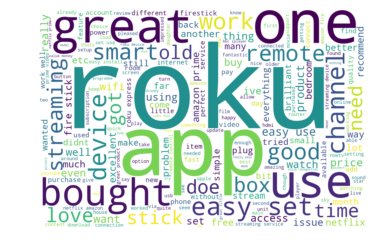

In [10]:
#create a word cloud
createWordCloud(df["Edited Review"])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


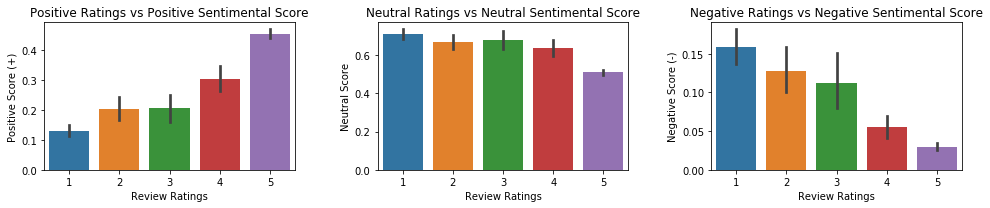

In [11]:
#graph Rating vs Compound score for positive, negative, and neutral reviews separately
threeBarPlots(reviews_vader)

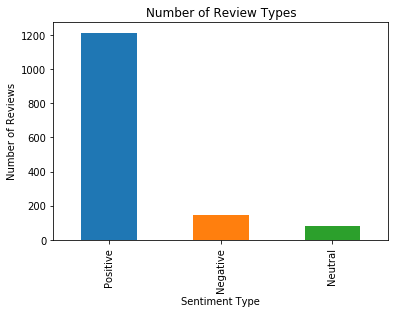

In [12]:
#graph the number of positive, negative, and neutral reviews
reviewTypeCount(reviews_vader)

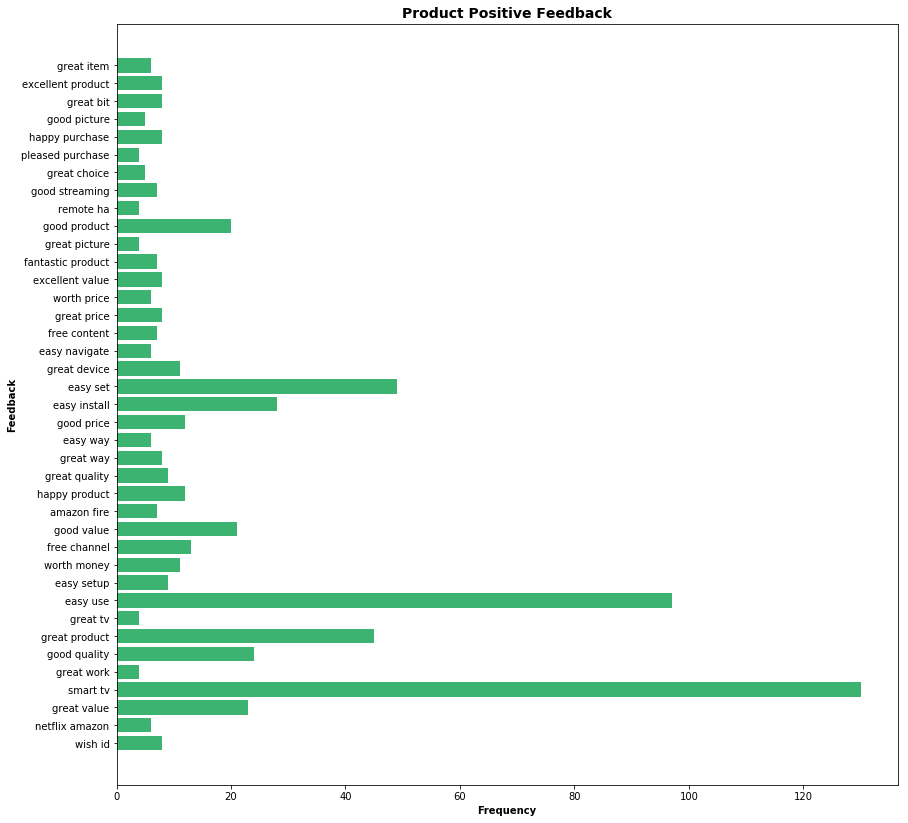

In [13]:
#Positive Feedback
typeOfReviews = 'Positive'

#color Choices: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png
color = 'mediumseagreen' 

#find word pairing in 'adjective noun' form
keyWordPairs = findConnectingReviews(reviews_vader[reviews_vader['analysis'] == typeOfReviews]["Edited Review"], typeOfReviews)

#find the number of frequencies
pairFreq = findFreq(keyWordPairs)
xAxis = list(pairFreq.values())
yAxis = list(pairFreq.keys())

#create horizontal bar plot
feedbackBarPlot(xAxis, yAxis, typeOfReviews, color)

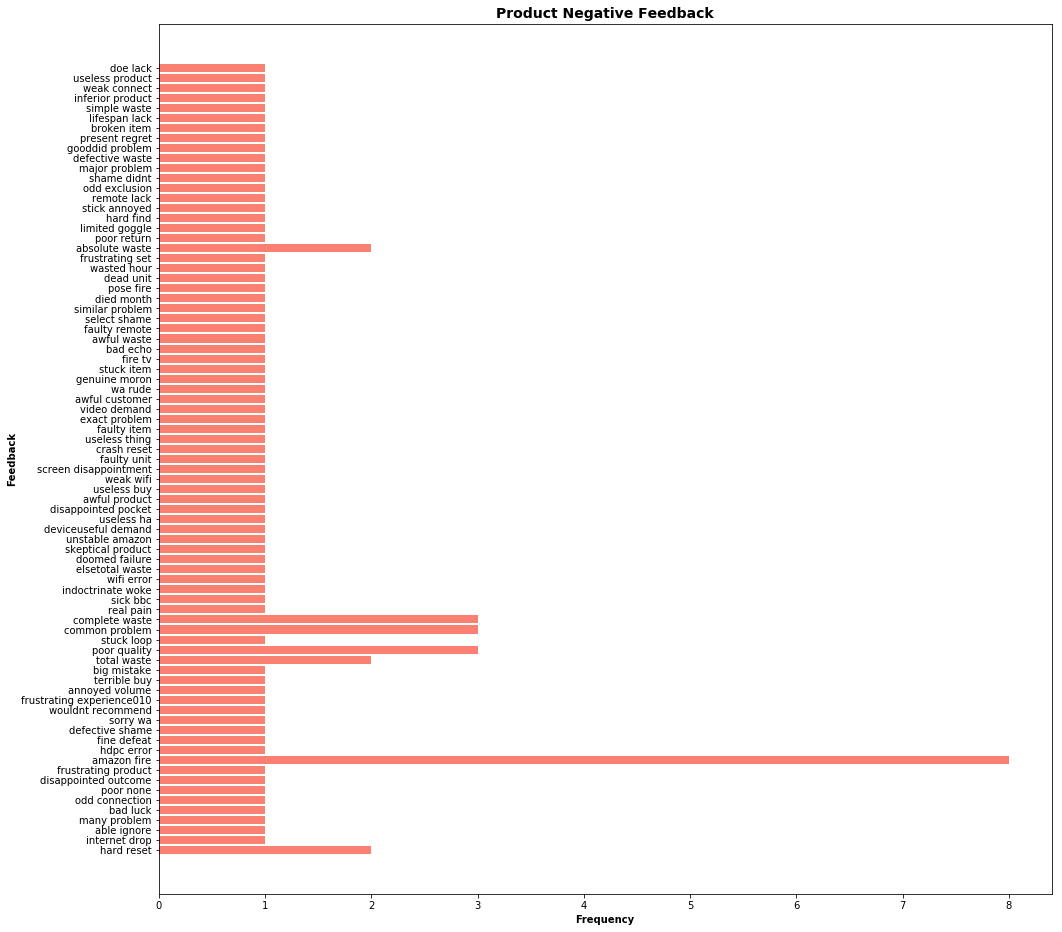

In [14]:
#Negative Feedback
typeOfReviews = 'Negative'

#color Choices: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png
color = 'salmon' 

#find word pairing in 'adjective noun' form
keyWordPairs = findConnectingReviews(reviews_vader[reviews_vader['analysis'] == typeOfReviews]["Edited Review"], typeOfReviews)

#find the number of frequencies
pairFreq = findFreq(keyWordPairs)
xAxis = list(pairFreq.values())
yAxis = list(pairFreq.keys())
len(pairFreq)
#create horizontal bar plot
feedbackBarPlot(xAxis, yAxis, typeOfReviews, color)